<a href="https://colab.research.google.com/github/pravittuteja/Neural-Style-Transfer/blob/master/NST_Pravit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow 1.x selected.
Eager execution: True
Welcome to this app where you can stylize your photos!


Please give the path of your photo that you want to style: (___.jpg)
/content/drive/My Drive/neuralstyletransfer-master/lerone-pieters-vF6mSAWAzzU-unsplash.jpg
Your Selected Image


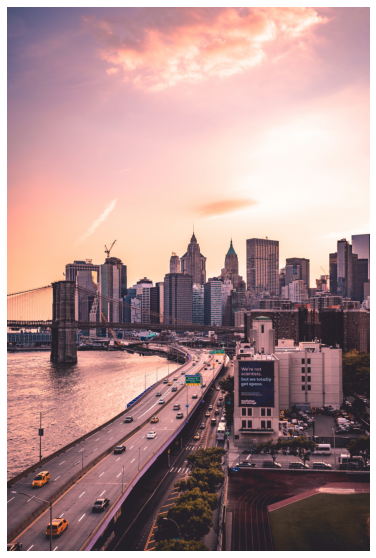

Please select the style: 




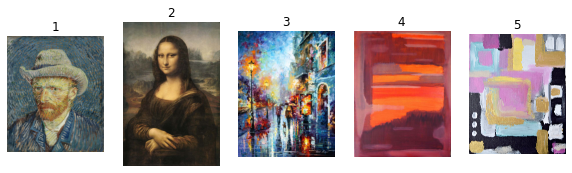

5


 12%|█▎        | 125/1000 [00:10<01:11, 12.26it/s]

In [ ]:
# -*- coding: utf-8 -*-
"""neuralstyletransfer.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1BZFBzj0fddJhActtfyckLT5z6YicVvUl
"""
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models, losses, layers 
from tensorflow.python.keras import backend as K
import numpy as np
from PIL import Image
import time
import functools
import matplotlib.pyplot as plt
import sys
import IPython.display
from tqdm import tqdm
from time import sleep

# VGG19 layers to be used
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

def prepare_image(path):
  image = Image.open(path)
  scale = 512/max(image.size)
  image = image.resize((round(image.size[0]*scale), round(image.size[1]*scale)), Image.ANTIALIAS)
  image = kp_image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  return image

def display_image(img, title=None):
  out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

def display_best_image(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)

  # VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR

  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

def load_VGG():
  # Load VGG19. 
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  s_out = [vgg.get_layer(name).output for name in style_layers]
  c_out = [vgg.get_layer(name).output for name in content_layers]
   
  return models.Model(vgg.input, s_out + c_out)

def gram_matrix(tens):
  channels = int(tens.shape[-1])
  style = tf.reshape(tens, [-1, channels])
  
  return tf.matmul(style, style, transpose_a=True) / tf.cast(tf.shape(style)[0], tf.float32)

def feature_rep(model, content_path, style_path):
  # Load our images in 
  content_image = tf.keras.applications.vgg19.preprocess_input(prepare_image(content_path))
  style_image = tf.keras.applications.vgg19.preprocess_input(prepare_image(style_path))
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Here 5 is the number of style layers  
  style_features = [style_layer[0] for style_layer in style_outputs[:5]]
  content_features = [content_layer[0] for content_layer in content_outputs[5:]]
  return style_features, content_features

def loss_total(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:5]
  content_output_features = model_outputs[5:]
  
  style_score = 0
  content_score = 0

  # We have 5 style layers
  for target_style, combined_style in zip(gram_style_features, style_output_features):
    style = tf.reduce_mean(tf.square(gram_matrix(combined_style) - target_style)) / 5.0
    style_score = style_score + style
    
  # Since we take just one layer for content features
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += tf.reduce_mean(tf.square(comb_content[0] - target_content))
  
  style_score = style_score*style_weight
  content_score = content_score*content_weight

  # Get total loss
  total_loss = style_score + content_score 
  return total_loss, style_score, content_score

def run_style_transfer(content_path, style_path, iteration): 
      
  # Use pre-trained model to get feature representations
  model = load_VGG() 
  for layer in model.layers:
    layer.trainable = False
  style_features, content_features = feature_rep(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = tf.keras.applications.vgg19.preprocess_input(prepare_image(content_path))
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  best_loss, best_img = float('inf'), None
  
  setup = {'model': model, 'loss_weights': (1e-2, 1e3), 'init_image': init_image, 'gram_style_features': gram_style_features,
      'content_features': content_features}
    
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   

  for i in tqdm(range(iteration)):
    with tf.GradientTape() as tape: 
      losses = loss_total(**setup)
    loss = losses[0]
    grads, all_loss = tape.gradient(loss, setup['init_image']), losses
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped) 
    
    if loss < best_loss:
      best_loss = loss
      best_img = display_best_image(init_image.numpy())
    #print("Best Loss: ", best_loss)
  return best_img, best_loss

def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = prepare_image(content_path) 
  style = prepare_image(style_path)

  plt.subplot(1, 2, 1)
  plt.axis('off')
  display_image(content, 'Content Image')

  plt.subplot(1, 2, 2)
  plt.axis('off')
  display_image(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.axis('off')
    plt.title('Output Image')
    plt.show()

  print("Do you want to start again? (y/n)")
  answer = str(input())
  if answer == 'y':
    ultimate_cell()
  else:
    sys.exit(1)

import matplotlib.image as mpimg
def show_styles(content_path):
  style1path = '/content/drive/My Drive/neuralstyletransfer-master/style1.jpg'
  style2path = '/content/drive/My Drive/neuralstyletransfer-master/style2.jpg'
  style3path = '/content/drive/My Drive/neuralstyletransfer-master/style3.jpg'
  style4path = '/content/drive/My Drive/neuralstyletransfer-master/style4.jpg'
  style5path = '/content/drive/My Drive/neuralstyletransfer-master/geordanna-cordero-9XAQt2z4tCc-unsplash.jpg'

  style1 = mpimg.imread(style1path)
  style2 = mpimg.imread(style2path)
  style3 = mpimg.imread(style3path)
  style4 = mpimg.imread(style4path)
  style5 = mpimg.imread(style5path)

  plt.figure(1)

  plt.subplot(151)
  plt.imshow(style1)
  plt.axis('off')
  plt.title('1')

  plt.subplot(152)
  plt.imshow(style2)
  plt.axis('off')
  plt.title('2')

  plt.subplot(153)
  plt.imshow(style3)
  plt.axis('off')
  plt.title('3')

  plt.subplot(154)
  plt.imshow(style4)
  plt.axis('off')
  plt.title('4')

  plt.subplot(155)
  plt.imshow(style5)
  plt.axis('off')
  plt.title('5')

  plt.show()

  n = int(input())

  if n==1:
    style_path = style1path
  elif n==2:
    style_path = style2path
  elif n==3:
    style_path = style3path
  elif n==4:
    style_path = style4path
  elif n==5:
    style_path = style5path
  else:
    print("Please enter a valid style number (1, 2, 3, 4 or 5)")

  best, best_loss = run_style_transfer(content_path, style_path, iteration=1000)  
  #Image.fromarray(best)
  show_results(best, content_path, style_path)

def ultimate_cell():


  print("Welcome to this app where you can stylize your photos!")
  print("\n")
  print("Please give the path of your photo that you want to style: (___.jpg)")
  content_path = str(input(""))

  
  try: 
    content = mpimg.imread(content_path)
    print("Your Selected Image")
    plt.figure()
    plt.imshow(content)
    plt.axis('off')
    plt.show()
  except:
    print("\n")
    print("Enter a valid image")
    print("\n")
    sys.exit(1)

  print("Please select the style: ")
  print("\n")


  show_styles(content_path)

def run():
  ultimate_cell()

run()

In [ ]:
# -*- coding: utf-8 -*-
"""main.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Fsr7-s4mT7YldN-QaEZxANCtz_wlMvt_
"""

#import neuralstyletransfer

!pip install libsvm
!pip install pybrisque

from libsvm import svmutil
from brisque.brisque import *

brisq = BRISQUE()

brisq.get_feature("/content/drive/My Drive/neuralstyletransfer-master/bird.jpg")

brisq.get_score("/content/drive/My Drive/neuralstyletransfer-master/bird.jpg")